# Compare Biomarkers

There are two ways to generate biomarkers with Seurat; `FindAllMakrers` or `FindConserverdMarkers`. The first ignore replicate information and looks for biomarkers by comparing clusters. The second is slightly more conservative where it looks for markers independently for each replicate and then does a meta analysis to combine p-values and determine significance. I don't think there should be much differences, but the second should be a little more conservative and may provide a better list.

Also I compare these new results with my previous buggy results to get a feeling for what has changed.

We had selected lines from the preliminary analysis when we only had 1 replicate. Now that we have our final analysis with 3 replicates I wanted to go back and see what genes from the validation set we lost. We can remove these from our summarizations.

In [1]:
# Imports
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs
from larval_gonad.config import memory
from larval_gonad.scRNAseq import T2A, GAL4, WHITE, PTRAP

# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq_combine_force')

last updated: 2018-05-16 
Git hash: 2ab7e147bd4d8cf2b5529684ed180aa07ed7c54e


In [2]:
biomarkers1 = pd.read_csv(Path(nbconfig.seurat_dir, 'biomarkers_res.0.6.tsv'), sep='\t', index_col=[0, 1])
biomarkers2 = pd.read_csv(Path(nbconfig.seurat_dir, 'biomarkers_conserved_res.0.6.tsv'), sep='\t', index_col=[0, 1])

In [38]:
sig1 = biomarkers1.query('p_val_adj <= 0.001').index.get_level_values('gene_symbol').unique().tolist()
sig2 = biomarkers2.query('max_pval <= 0.001').index.get_level_values('gene_symbol').unique().tolist()
print(f"FindMarkers: {len(sig1):,}")
print(f"FindConservedMarkers: {len(sig2):,}")

FindMarkers: 5,022
FindConservedMarkers: 3,560


In [102]:
def check(target, sig):
    _vals = [x for x in target if x not in sig]
    print(f'{len(_vals)} / {len(target)} * 100 = {len(_vals) / len(target) * 100:0.2f}%')
    return sorted(_vals)

## Check overlap between biomarker sets

I checked is conserved biomarkers was a subset, and `sxc` is only in the conserved biomarkers.

In [103]:
_val = check(sig2, sig1)
biomarkers2.query(f'gene_symbol == {_val}')

1 / 3560 * 100 = 0.03%


,,rep1_p_val,rep1_avg_logFC,rep1_pct.1,rep1_pct.2,rep1_p_val_adj,rep2_p_val,rep2_avg_logFC,rep2_pct.1,rep2_pct.2,rep2_p_val_adj,rep3_p_val,rep3_avg_logFC,rep3_pct.1,rep3_pct.2,rep3_p_val_adj,max_pval,minimump_p_val,cluster
primary_FBgn,gene_symbol,,,,,,,,,,,,,,,,,,
FBgn0261403,sxc,3.322581e-16,0.347986,0.441,0.153,4.809768e-12,5.314917e-68,0.263539,0.551,0.169,7.693873e-64,3.360811e-127,0.276966,0.332,0.071,4.865111e-123,3.322581e-16,1.008243e-126,6


While close to 30% of significant genes in `FindMarkers` are not in the `FindConservedMarkers`

In [104]:
_val = check(sig1, sig2)

1463 / 5022 * 100 = 29.13%


## Check overlap with previous biomarkers set.

I had noticed a bug in my code which caused me to have replicate 2 twice. I have fixed this and I am re-running everything. Here I want to check out similar these old results are to the new results. A direct comparison is hard because the clusters are different.

In [105]:
old_biomarkers = pd.read_csv('https://helix.nih.gov/~fearjm/larval_gonad/combined_testis_force/biomarkers_0.4.tsv', sep='\t')
oldSig = old.query('p_val_adj <= 0.001').gene_symbol.unique().tolist()

Of the 5,750 genes in the original (buggy) biomarkers list, only 917 (16%) did not come out in the new list. If I look at cluster counts, I see that the majority of these differences are from clusters 8 and 11. Cluster 8 was an early 1º spermatocyte cluster and cluster 11 was possibly mid/late 1º spermatocytes.

In [106]:
_val = check(oldSig, sig1)
old_biomarkers.query(f'gene_symbol in {_val}').cluster.value_counts()

917 / 5750 * 100 = 15.95%


8     545
11    164
6      99
9      68
7      55
10     51
4      44
5      30
1       6
3       5
2       3
0       3
Name: cluster, dtype: int64

The majority of missing biomarkers in the new set are from 1 cluster.

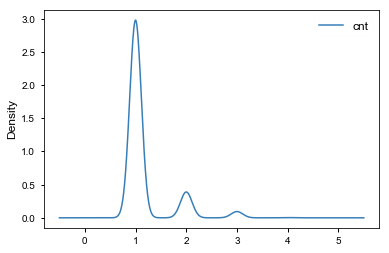

In [108]:
res = []
for v in _val:
    try:
        cnt = old_biomarkers.query(f'gene_symbol == "{v}"').shape[0]
        res.append((v, cnt))
    except KeyError:
        continue

df = pd.DataFrame(res, columns=['gene', 'cnt'])
df.sort_values(by='cnt', ascending=False).plot(kind='kde')

## What biomarkers did we remove from validation sets

When I had run a very preliminary analysis (rep 1 only) we had selected a set of genes for validating clusters by mapping there protein expression back onto the testis. I want to see how many if any we have lost in the new analysis. Mostly so we can leave them out of the summary.

### T2A Gal4

In [109]:
print(check(T2A, sig1))
print(check(T2A, sig2))

9 / 27 * 100 = 33.33%
['CG11658', 'CG34394', 'CG7255', 'Eaf', 'Ino80', 'Khc-73', 'RasGAP1', 'Su(var)2-10', 'tun']
11 / 27 * 100 = 40.74%
['CG11658', 'CG34383', 'CG34394', 'CG42458', 'CG7255', 'Eaf', 'Ino80', 'Khc-73', 'RasGAP1', 'Su(var)2-10', 'tun']


### Gal4

In [110]:
print(check(GAL4, sig1))
print(check(GAL4, sig2))

8 / 39 * 100 = 20.51%
['AdamTS-A', 'CG11658', 'CG9272', 'CadN ', 'Papss', 'eya', 'rau', 'sano']
14 / 39 * 100 = 35.90%
['AdamTS-A', 'CG11658', 'CG34383', 'CG9272', 'CadN ', 'Meltrin', 'Notum', 'Papss', 'eya', 'mael', 'rau', 'sano', 'svp', 'svp']


### Ben White Set

We don't expect these to be in the list because we just ran what lines we had from Ben White.

In [111]:
print(check(WHITE, sig1))
print(check(WHITE, sig2))

19 / 19 * 100 = 100.00%
['AkhR', 'CG2187', 'ChaT', 'CrzR', 'Dh31R', 'EH', 'EHR', 'ETHR', 'ETHR', 'ETHRB', 'GluRIIB', 'HR46', 'HR46', 'LGR1', 'Proc', 'ProcR', 'burs', 'pburs', 'rk']
19 / 19 * 100 = 100.00%
['AkhR', 'CG2187', 'ChaT', 'CrzR', 'Dh31R', 'EH', 'EHR', 'ETHR', 'ETHR', 'ETHRB', 'GluRIIB', 'HR46', 'HR46', 'LGR1', 'Proc', 'ProcR', 'burs', 'pburs', 'rk']


### Protein Traps from Erika's Lab

In [112]:
print(check(PTRAP, sig1))
print(check(PTRAP, sig2))

8 / 71 * 100 = 11.27%
['CG11044', 'CG3277', 'CG43373', 'CadN', 'Efa6', 'Rab3', 'p130CAS', 'stg']
19 / 71 * 100 = 26.76%
['Ance', 'CG11044', 'CG3277', 'CG42321', 'CG43373', 'CadN', 'DIP-delta', 'Efa6', 'Pvr', 'Rab3', 'Wdr62', 'foxo', 'fru', 'hid', 'p130CAS', 'sdk', 'stg', 'svp', 'tutl']
